# Sync vs async methods of making API calls

In Python, synchronous and asynchronous API requests refer to different ways of sending and receiving data from an external API or web service.

Synchronous API requests are blocking, meaning that when a request is made, the program waits for the response to come back before continuing with any other tasks. This can be useful in situations where the response is required immediately and no other tasks need to be performed until the response is received.

On the other hand, asynchronous API requests are non-blocking, meaning that when a request is made, the program continues to execute other tasks while waiting for the response to come back. This can be useful in situations where multiple requests need to be made at the same time or when the response time is unpredictable, allowing the program to continue working on other tasks while waiting for the response.

The importance of synchronous and asynchronous API requests depends on the specific use case. For example, synchronous requests may be preferred when working with small, simple APIs that require immediate responses, while asynchronous requests may be necessary when working with large, complex APIs that require many requests to be made at the same time.

In this notebook, we use the IUCN API to demonstrate synchronous and asynchronous methods of getting API data. Here, we time each method and demonstrate the individual use cases.

In [1]:
# Import required modules
import pytest
import timeit
import re
import requests
import responses
import json 
import time
import asyncio
from concurrent.futures import ThreadPoolExecutor
from configparser import ConfigParser

In [2]:
# Get IUCN API key from config.ini
config = ConfigParser()
config.read("config.ini")
IUCN_API_KEY = config["API"]["iucn"]

## Create required functions

### Function that makes get request and handles exceptions

Here, we create a function that makes get requets to a url and catches exceptions raised. Using error handling, we give custom exception messages to make troubleshooting a bit easier.

In [3]:
def get_url_response(url):
    """
    Makes get request using requests library to specified url.

    Args:
        url (str): url to make request to

    Returns:
        response: request response object

    Raises:
        requests.exceptions.HTTPError ("Token not valid!"): Provided token is not accepted
        requests.exceptions.HTTPError (HTTPError. Request failed with response status: {response.status_code}, see the following link for more detail on this status: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/{response.status_code})
        requests.exceptions.ConnectionError (Connection Error. Error connecting to server url:{url}. Following error raised: {e})
        requests.exceptions.RequestException (Request Exception. An error occurred while making the request: {e})
    
    """
    try:
        response = requests.get(url)
    except requests.exceptions.ConnectionError as e:
        raise requests.exceptions.ConnectionError(f"Connection Error. Error connecting to server url:{url}. Following error raised: {e}")
    except requests.exceptions.RequestException as e:
        raise requests.exceptions.RequestException(f"An error occurred while making the request: {e}")
    if response.text == '{"message":"Token not valid!"}':
        raise requests.exceptions.HTTPError("Token not valid!")
    elif response.status_code != 200:
        raise requests.exceptions.HTTPError(f"HTTPError. Request failed with response status: {response.status_code}, see the following link for more detail on this status: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/{response.status_code}")
    else:
        pass
    return response

### Test get_url_response()

When you create a bespoke function, it's important to test that the function works as expected. Below, we test the get_url() function. 

When testing the function, we can create mock HTTP Response Object with `responses.RequestsMock()` from the `requests` library. We can define the mock response (the JSON object and status code) using `rsps.add()`.

In [4]:
def test_get_request_sucess():
    """ Test for successful request """
    # set up response object that gives success status 200
    with responses.RequestsMock() as rsps:
        rsps.add(responses.GET, 'https://api.example.com/data',
                 json={'data': 'example'}, status=200)
        response = get_url_response('https://api.example.com/data')
        assert response.status_code == 200
        assert response.json() == {'data': 'example'}

def test_get_request_failed_responsecode():
    """ Test for failed request """
    with responses.RequestsMock() as rsps:
        rsps.add(
            responses.GET, 
            'https://api.example.com/data',
            json={'error': 'Request failed'},
            status=500
        )
        with pytest.raises(requests.exceptions.HTTPError) as exc_info:
            get_url_response('https://api.example.com/data')
        assert str(exc_info.value) == "HTTPError. Request failed with response status: 500, see the following link for more detail on this status: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/500"

def test_get_request_failed_token():
    """ Test for failed request """
    with responses.RequestsMock() as rsps:
        rsps.add(
            responses.GET, 
            'https://api.example.com/data',
            body='{"message":"Token not valid!"}',
            content_type='application/json', 
            status=200
        )
        with pytest.raises(requests.exceptions.HTTPError) as exc_info:
            get_url_response('https://api.example.com/data')
        assert str(exc_info.value) == "Token not valid!"

def test_get_request_failed_url():
    """ Test for failed request """
    with pytest.raises(requests.exceptions.ConnectionError) as exc_info:
        get_url_response('https://api.example.com/invalid-url')
    # Get unique 
    error_message_result = str(exc_info.value)
    # Regular expression pattern
    pattern = r'0x[0-9a-fA-F]+'
    # Search for the pattern in the string
    match = re.search(pattern, error_message_result)
    error_message_expected = f"Connection Error. Error connecting to server url:https://api.example.com/invalid-url. Following error raised: HTTPSConnectionPool(host='api.example.com', port=443): Max retries exceeded with url: /invalid-url (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at {match.group()}>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))"
    assert error_message_result == error_message_expected

Run the test functions

In [5]:
test_get_request_sucess()
test_get_request_failed_responsecode()
test_get_request_failed_token()
test_get_request_failed_url()

### Timing the get url for multiple pages functions

You'll need this function for later to time how long the sync and async functions take to get a responce from a url when requesting multiple pages at a time.

In [6]:
def time_function(function_name, pages):
    """ 
    Time how long it takes to execute a function
    that requests multiple pages.
    """
    times = []
    for page in pages: # number of pages to request
        execution_time = timeit.timeit(lambda: function_name(page), number=1) 
        print(f"Execution time for {page} pages: {execution_time:.6f} seconds") 
        times.append((page, execution_time))
    return times

Test timer function

In [7]:
# Test'time_function'

maximum_pages = [1, 3, 5, 10]

# Create sample function for retrieving multiple pages from url
def get_multiple_pages_tester(maximum_pages):
    [get_url_response(f"http://httpbin.org/links/{page}") for page in range(maximum_pages)]

def test_time_function():
    result = time_function(get_multiple_pages_tester, maximum_pages)
    
    # Check if the execution times are positive.
    execution_times = [item[1] for item in result]
    assert all(execution_time >= 0 for execution_time in execution_times)
    
    # Check if the execution times are reasonable.
    # You can adjust these thresholds as needed.
    assert execution_times[0] < 1.0  # Execution time for 1 page should be less than 1 second.
    assert execution_times[1] < 2.0  # Execution time for 3 pages should be less than 2 seconds.
    assert execution_times[2] < 3.0  # Execution time for 5 pages should be less than 3 seconds.
    assert execution_times[3] < 7.0  # Execution time for 10 pages should be less than 7 seconds.

In [8]:
test_time_function()

Execution time for 1 pages: 0.291726 seconds


Execution time for 3 pages: 0.898044 seconds
Execution time for 5 pages: 2.046078 seconds
Execution time for 10 pages: 4.813973 seconds


## (1) Sync methods

### (1a) requests library

The `requests` library makes HTTP requests to a specified URL. You can use the library to set headers, encode and decode data, and handle redirects and authentication. The library will automatically parse the response and return a Response object. The `requests` library only allows for one page request at a time, you cant multiple send requests to run in parallel. The synchronous nature of the `requests` library means you have to wait until a response is recieved before you send the next response. This means the library is very slow when handling multiple requests, but works quickly for making a few requests. Below is a `requests` method for getting API data from a single IUCN page (note IUCN has 16 pages total).

In [9]:
def get_iucn_page(page: int = 0):
    """
    Makes GET request for specific IUCN page.
    """
    url = f"https://apiv3.iucnredlist.org/api/v3/species/page/{page}?token={IUCN_API_KEY}"
    url_responce = get_url_response(url)
    return url_responce.json()

In [10]:
def get_multiple_iucn_pages_synchronously(maximum_page: int = 0):
    """ 
    Gets multiple pages from IUCN API synchronously using requests module.

    Args:
        maximum_page (int): the maximum number of pages to request, e.g., 16

    Returns:
        None
    """
    [get_iucn_page(page) for page in range(maximum_page)]

## (2) Async methods

Asynchronous methods involves making and processing get requests in parallel to speed up large numbers of HTTP requests. It works by sending multiple requests at once (rather than one-by-one) and processing the responses as they are recieved. Here we explore two methods for making API requests asynchronously. The first method uses the `ThreadPoolExecutor` library, and the second method uses the two libraries `asyncio` and `aiohttp`.

### (2a) ThreadPoolExecutor

ThreadPoolExecutor is a class from the `concurrent.futures` module that allows you to create a pool of worker threads to execute tasks concurrently. Each thread can make and process a HTTP request. You can use it to run multiple get requests (as seperate threads) in parallel by submitting them to the executor and then waiting for the results. Each time ThreadPoolExecutor creates a new thread, there is a small amount of overhead involved, so if the time it takes to make the request is relatively short, this overhead can make the overall execution time longer than using the synchronous requests module. `ThreadPoolExecutor` is optimal when used to make multiple requests that take time to recieve a response for/ process.

In [11]:
def get_multiple_iucn_pages_using_threads(maximum_page: int = 0):
    """ 
    Gets multiple pages from IUCN API in parallel using threads.
    """
    with ThreadPoolExecutor() as executor:
        results = [executor.submit(get_iucn_page, page) for page in range(maximum_page)] # executor.submit() starts the pool of threads
    return results

In [12]:
# If you want to access the data from the Future responce
data = get_multiple_iucn_pages_using_threads(2)
thread_results = []
# Wait for all threads to complete and retrieve the results
for thread in data:
    result = thread.result()  # Get the result from each thread
    thread_results.append(result)

# Print some of the information (its a big json so Jupyter cant load whole thing)
print([thread_results[page_num]["count"] for page_num in [0, 1]])

[10000, 10000]


### (2b) asyncio & aiohttp

`asyncio` and `aiohttp` are Python libraries that work together to make asynchronous HTTP requests. 

**How does asyncio work?**

Asyncio uses coroutines which are awaitable functions that work simarly to generators. Generators are objects that contain iterables which, when requested using `yield`, are computed and stored in memory, while the rest of the iterables are never generated until they are requested. This means you can store an indefinate number of values without using storage space, its not until you call for the value using `next` that it then gets stored in memory. Variables and functions, on the other hand, compute all values in advance and store them in memory. Coroutines work like generators, they are functions that arent executed or stored in memory until called. They are declared with the async and await syntax.

<b>Function vs Generator</b>
<br>
<br>
Functions compute and store all values in advance. This means, if you make get requests using a function (see `get_multiple_pages_non_generator()` example below), then the function would make all the requests, store all the responses in memory and return all the response objects together.

In [13]:
def get_multiple_pages_non_generator(maximum_pages):
    results_list = []
    for page in range(maximum_pages):
        result = get_url_response(f"http://httpbin.org/links/{page}") 
        results_list.append(result)
    return results_list

results = get_multiple_pages_non_generator(4)
print(results)

[<Response [200]>, <Response [200]>, <Response [200]>, <Response [200]>]


Generators, instead of building an array containing all the values and returning them all at once (like with functions), yields values one at a time (using the `next` keyword), which requires less memory and allows the caller to get started processing the first few values immediately.

In [14]:
# Example generator function
def get_multiple_pages_generator(maximum_pages):
    for page in range(maximum_pages):
        result = get_url_response(f"http://httpbin.org/links/{page}") 
        yield result

responses = get_multiple_pages_generator(4)

In [15]:
next(responses)

<Response [200]>

<b>Coroutines</b>
<br>
<br>
Similar to generators, coroutines can be paused and resumed, only generating values as needed. They also have the ability to receive values from the caller, simarly to generators. This is particularly important as it means coroutines and be suspended and resumed later, allowing other tasks to run in the meantime. Asyncio allows you to run processes in parallel by running two or more coroutines concurrently.

In the example below, we run multiple async functions and process them concurrently which means the functions dont return values in the order of their execution.

In [16]:
# create tasks
async def count():
    print("count one")
    await asyncio.sleep(8)
    print("count two")

async def count_further():
    print("count three")
    await asyncio.sleep(4)
    print("count four")

async def count_even_further():
    print("count five")
    await asyncio.sleep(6)
    print("count six")

async def main():
    await asyncio.gather(count(), count_further(), count_even_further()) # gather tasks and await their excecution in the event loop

s = time.perf_counter()
await main()
elapsed = time.perf_counter() - s # time elapsed between starting and ending awaition for async function to finish processing
print(f"Script executed in {elapsed:0.2f} seconds.")

count one
count three
count five
count four
count six
count two
Script executed in 8.00 seconds.


<b>Event loop</b>
<br>
<br>
Asyncio uses an Event Loop to manage and coordinate the execution of asynchronous tasks and events. In Jupyter, an Event Loop is already setup and runs in the main thread. If you try to create a new Event Loop in Jupyter, you will recieve an error (see below).

In [17]:
import asyncio
loop = asyncio.get_event_loop()
print(loop)
pending = asyncio.all_tasks()
print(pending)
try:
    asyncio.get_event_loop().run_until_complete(asyncio.gather(*asyncio.all_tasks()))
except RuntimeError as r:
    print(r)

<_WindowsSelectorEventLoop running=True closed=False debug=False>
{<Task pending name='Task-3' coro=<Kernel.dispatch_queue() running at c:\Users\sarah\anaconda3\envs\api-env\lib\site-packages\ipykernel\kernelbase.py:510> cb=[IOLoop.add_future.<locals>.<lambda>() at c:\Users\sarah\anaconda3\envs\api-env\lib\site-packages\tornado\ioloop.py:687]>}
This event loop is already running


If you want to run an additional Event Loop in Jupyter you can use the [nest-asyncio](https://pypi.org/project/nest-asyncio) package, otherwise, you can simply add your async tasks to the already running Event Loop.

<b>Multiple page request using asyncio</b>
<br>
<br>
Now we understand how asyncio works, we can go ahead and create our asyncio function for requesting multiple IUCN pages.

In [18]:
import asyncio
import aiohttp

async def get_iucn_page_asyncio(session, page_number):
    url = f"http://apiv3.iucnredlist.org/api/v3/species/page/{page_number}?token={IUCN_API_KEY}"
    try:
        async with session.get(url) as response:
            if response.text == '{"message":"Token not valid!"}':
                raise Exception("Token not valid!")
            elif response.status == 404:
                print(f"Page {page_number} not found")
            elif response.status != 200:
                raise Exception(
                    f"Request failed with response status: {response.status}"
                )
            else:
                return await response.json()
    except aiohttp.ClientError as e:
        print(f"Error occured while getting page {page_number} : {e}")
        return None


async def get_multiple_iucn_pages_asyncio(maximum_page):
    async with aiohttp.ClientSession() as session:
        tasks = [get_iucn_page_asyncio(session, page_number) for page_number in range(maximum_page)] # create a task for each page request
        results = await asyncio.gather(*tasks) # gather tasks and wait for them to process
        return results


### Compare times between the 3 methods
- Synchronous requests
- Async threads
- Asyncio coroutines

In [19]:
maximum_pages = [1, 3, 5, 10]

Sync method

In [20]:
sync_times = time_function(get_multiple_iucn_pages_synchronously, maximum_pages)

Execution time for 1 pages: 1.441543 seconds
Execution time for 3 pages: 3.055750 seconds
Execution time for 5 pages: 9.613632 seconds
Execution time for 10 pages: 13.647291 seconds


Async method using ThreadPool

In [21]:
async_times = time_function(get_multiple_iucn_pages_using_threads, maximum_pages)

Execution time for 1 pages: 5.014806 seconds
Execution time for 3 pages: 3.025616 seconds
Execution time for 5 pages: 8.901578 seconds
Execution time for 10 pages: 21.133541 seconds


Async method using asyncio

In [22]:
for max_page in maximum_pages:
    s = time.perf_counter()
    await get_multiple_iucn_pages_asyncio(max_page)
    elapsed = time.perf_counter() - s
    print(f"Execution time for {max_page} pages: {elapsed:0.2f} seconds.")

Execution time for 1 pages: 5.64 seconds.
Execution time for 3 pages: 4.76 seconds.
Execution time for 5 pages: 6.19 seconds.
Execution time for 10 pages: 19.33 seconds.


### Plot results

In [23]:
import matplotlib.pyplot as plt

def plot_results(times):
    # x axis values
    x = [i[0] for i in times] # page number
    # corresponding y axis values
    y = [i[1] for i in times] # execution time
    
    # plotting the points 
    plt.plot(x, y)
    
    # naming the x axis
    plt.xlabel('page number')
    # naming the y axis
    plt.ylabel('execution time (sec)')
    
    # giving a title to my graph
    plt.title('Increasing synchronous requests')
    
    # function to show the plot
    return plt

Plot showing that the time taken to make multiple get requests with the `requests` library increases linearly.

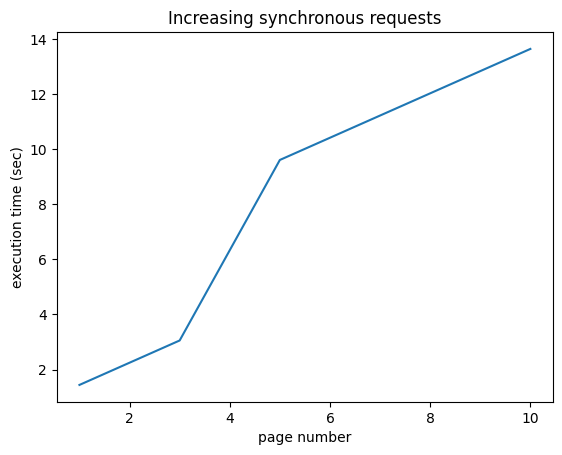

In [24]:
plot_sync = plot_results(sync_times)
plot_sync.show()